In [17]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import fAux
import mc_permutation
import detrendPrice 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight


import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr

import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels


In [53]:
spy = pd.read_csv('data/spy.csv', index_col='date', parse_dates=True)
nvda = pd.read_csv('data/nvda.csv', index_col='date', parse_dates=True)
nvda.head()

,close,high,low,open,volume,ticker
date,,,,,,
1999-01-22,0.037609,0.044772,0.035579,0.040116,2714688000,nvda
1999-01-25,0.041549,0.042026,0.037609,0.040594,510480000,nvda
1999-01-26,0.038325,0.042862,0.037728,0.042026,343200000,nvda
1999-01-27,0.038206,0.039400,0.036295,0.038444,244368000,nvda
1999-01-28,0.038086,0.038444,0.037848,0.038206,227520000,nvda


In [65]:
# model for longing
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    df = df.copy()
    future_max = df['close'].shift(-1).rolling(window=lookahead).max()
    future_return = (future_max - df['close']) / df['close']
    df['target_long'] = (future_return >= threshold).astype(int)
    return df

def feature_engineering(df):
    df = df.copy()
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']
    # Add more features as needed
    df.dropna(inplace=True)
    return df

def feature_engineering_2(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()
    spy_ret5 = spy['close'].pct_change(periods=5).fillna(0)
    df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')
    df.dropna(inplace=True)
    return df

def plot_model_metrics(y_true, y_proba, model_name):
    y_pred = (y_proba >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f'{model_name} - Confusion Matrix')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])
    axes[1].set_title(f'{model_name} - ROC Curve (AUC = {roc_auc:.2f})')

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')

    plt.tight_layout()
    plt.show()


def xgb_with_metrics(X, y, predict_proba_threshold=0.5):
    tscv = TimeSeriesSplit(n_splits=5)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42
    }

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(params, dtrain, num_boost_round=100)
        y_pred = (model.predict(dtest) >= predict_proba_threshold).astype(int)
        print(f'Fold {i+1} - XGBoost:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            y_proba = model.predict(dtest)
            plot_model_metrics(y_test, y_proba, "XGBoost")

    return model


In [55]:
nvda_v1 = nvda.copy()
nvda_v1 = create_target_long(nvda_v1, threshold=0.02, lookahead=5)
nvda_v1 = feature_engineering(nvda_v1)
print(nvda_v1.shape)
nvda_v1.head()

(6630, 18)


,close,high,low,open,volume,ticker,target_long,sma30,sma10,sma_diff,sma_slope,std30,bollinger_upper,bollinger_lower,percent_b,bollinger_z,rsi14,prod_bollingerz_rsi
date,,,,,,,,,,,,,,,,,,
1999-03-05,0.040235,0.040354,0.038444,0.038444,78768000,nvda,1,0.038858,0.041453,0.002595,0.000036,0.002735,0.044328,0.033389,0.625865,0.503459,52.036081,32.567553
1999-03-08,0.040832,0.042026,0.038444,0.039161,75888000,nvda,1,0.038966,0.041525,0.002559,0.000072,0.002747,0.044460,0.033472,0.669837,0.679349,53.636065,35.927437
1999-03-09,0.042146,0.042743,0.040713,0.040713,143184000,nvda,0,0.038986,0.041537,0.002551,0.000012,0.002769,0.044523,0.033449,0.785379,1.141517,57.033799,44.793166
1999-03-10,0.041429,0.042743,0.040832,0.042743,235344000,nvda,0,0.039089,0.041143,0.002054,-0.000394,0.002801,0.044691,0.033488,0.708852,0.835407,54.678888,38.759230
1999-03-11,0.039638,0.041429,0.039638,0.040713,54288000,nvda,1,0.039137,0.040713,0.001576,-0.000430,0.002797,0.044732,0.033542,0.544799,0.179196,49.213726,26.811594


In [33]:
# baseline model
feats = [
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14'
]
X = nvda_v1[feats]
y = nvda_v1['target_long']

tscv = TimeSeriesSplit(n_splits=5)

# check class balance
print(y.value_counts(normalize=True))

# models see below
# 1. Logistic Regression with time series cross-validation
# 2. Random Forest with time series cross-validation
# 3. XGBoost with time series cross-validation  
# 4. (LSTM not implemented since time lagging features are not created yet)


target_long
1    0.528356
0    0.471644
Name: proportion, dtype: float64


Fold 1 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.28      0.41       537
           1       0.58      0.92      0.71       568

    accuracy                           0.61      1105
   macro avg       0.68      0.60      0.56      1105
weighted avg       0.67      0.61      0.56      1105

Fold 1 visualized below


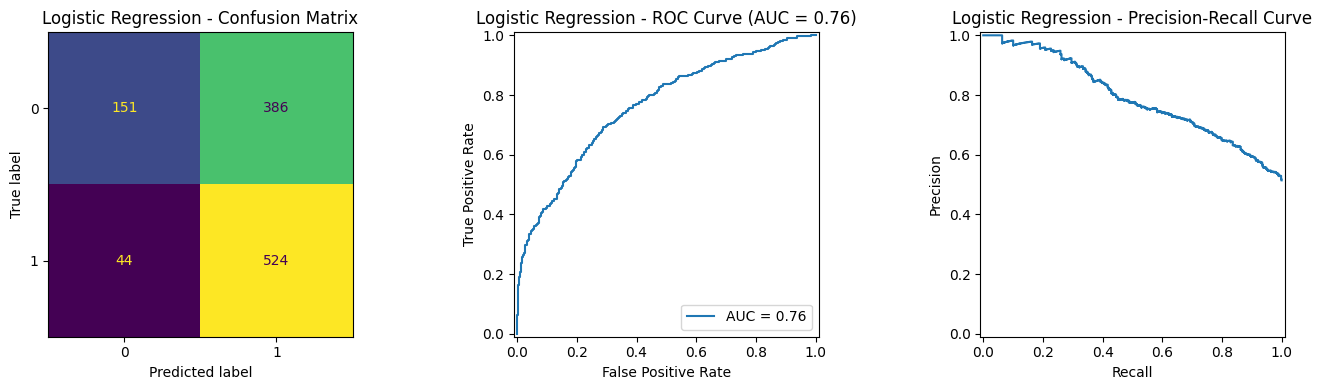

Fold 2 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      0.42      0.52       421
           1       0.71      0.88      0.78       684

    accuracy                           0.70      1105
   macro avg       0.69      0.65      0.65      1105
weighted avg       0.70      0.70      0.68      1105

Fold 3 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58       739
           1       0.44      0.90      0.59       366

    accuracy                           0.59      1105
   macro avg       0.67      0.67      0.59      1105
weighted avg       0.75      0.59      0.58      1105

Fold 4 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.55      0.32      0.40       606
           1       0.45      0.68      0.54       499

    accuracy                           0.48      1105
   macro avg       0.50      0.50     

In [34]:
# 1. logistic regression with time series cross-validation

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logistic_pipeline.fit(X_train, y_train)
    y_pred = logistic_pipeline.predict(X_test)
    print(f'Fold {i+1} - Logistic Regression:\n{classification_report(y_test, y_pred)}')
    
    if i == 0:
        print('Fold 1 visualized below')
        y_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
        plot_model_metrics(y_test, y_proba, "Logistic Regression")


### some notes for the metrics:
- task: enter high quality trades (even if its fewer)
- Precision: “When the model says BUY, how often is it right?”
- Recall: “Of all the good trade opportunities, how many did I catch?”
- We don't need to care about accuracy (e.g., it can be accurate but useless if it's mostly right about true neg (non-trade), like we won't enter the trade anyways)
- so overall, precision > recall > accuracy here

Fold 1 - Random Forest:
              precision    recall  f1-score   support

           0       0.73      0.27      0.39       537
           1       0.57      0.91      0.70       568

    accuracy                           0.60      1105
   macro avg       0.65      0.59      0.55      1105
weighted avg       0.65      0.60      0.55      1105

Fold 1 visualized below


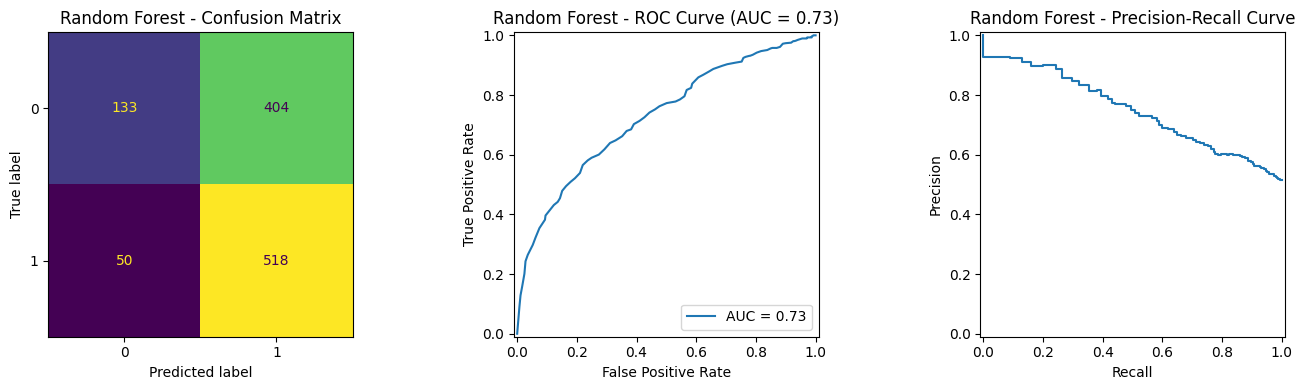

Fold 2 - Random Forest:
              precision    recall  f1-score   support

           0       0.61      0.49      0.55       421
           1       0.72      0.80      0.76       684

    accuracy                           0.69      1105
   macro avg       0.66      0.65      0.65      1105
weighted avg       0.68      0.69      0.68      1105

Fold 3 - Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       739
           1       0.48      0.84      0.61       366

    accuracy                           0.64      1105
   macro avg       0.67      0.69      0.64      1105
weighted avg       0.74      0.64      0.65      1105

Fold 4 - Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.46      0.56       606
           1       0.54      0.78      0.64       499

    accuracy                           0.61      1105
   macro avg       0.63      0.62      0.60      1105
we

In [35]:
# 2. random forest with time series cross-validation
rf = RandomForestClassifier(n_estimators=100, random_state=42)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f'Fold {i+1} - Random Forest:\n{classification_report(y_test, y_pred)}')

    if i == 0:
        print('Fold 1 visualized below')
        y_proba = rf.predict_proba(X_test)[:, 1]
        plot_model_metrics(y_test, y_proba, "Random Forest")


Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.63      0.18      0.28       537
           1       0.54      0.90      0.67       568

    accuracy                           0.55      1105
   macro avg       0.58      0.54      0.48      1105
weighted avg       0.58      0.55      0.48      1105

Fold 1 visualized below


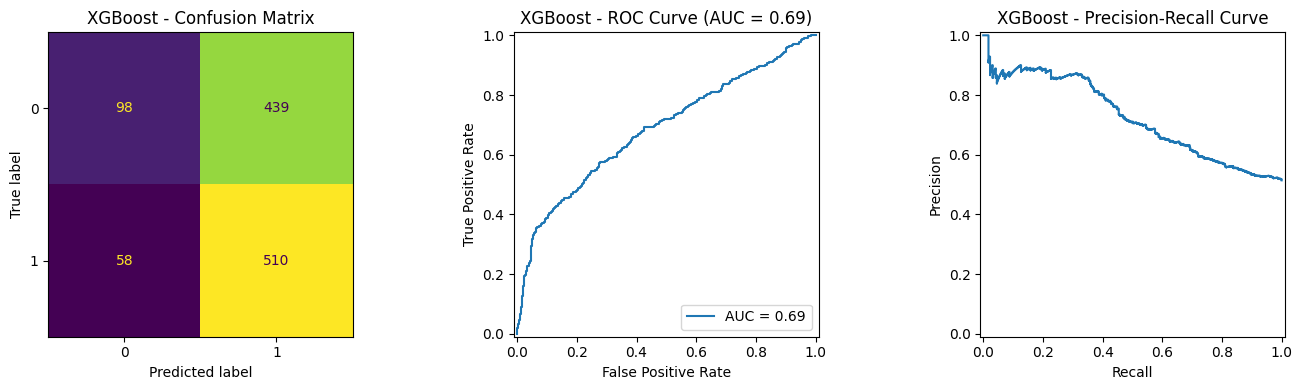

Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       421
           1       0.71      0.79      0.75       684

    accuracy                           0.67      1105
   macro avg       0.64      0.63      0.63      1105
weighted avg       0.66      0.67      0.66      1105

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.82      0.53      0.65       739
           1       0.45      0.76      0.56       366

    accuracy                           0.61      1105
   macro avg       0.63      0.65      0.60      1105
weighted avg       0.70      0.61      0.62      1105

Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       606
           1       0.57      0.74      0.65       499

    accuracy                           0.64      1105
   macro avg       0.65      0.64      0.63      1105
weighted avg       0

In [58]:
# 3. XGBoost with time series cross-validation
xgb_with_metrics(X, y)

In [39]:
nvda_v1.columns

Index(['close', 'high', 'low', 'open', 'volume', 'ticker', 'target_long',
       'sma30', 'sma10', 'sma_diff', 'sma_slope', 'std30', 'bollinger_upper',
       'bollinger_lower', 'percent_b', 'bollinger_z', 'rsi14',
       'prod_bollingerz_rsi'],
      dtype='object')

In [62]:
# model 2: try using more features
feats2 = [
    'volume',               
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14',
    'prod_bollingerz_rsi'
]

X2 = nvda_v1[feats2]
y2 = nvda_v1['target_long']

Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.64      0.20      0.31       537
           1       0.54      0.89      0.68       568

    accuracy                           0.56      1105
   macro avg       0.59      0.55      0.49      1105
weighted avg       0.59      0.56      0.50      1105

Fold 1 visualized below


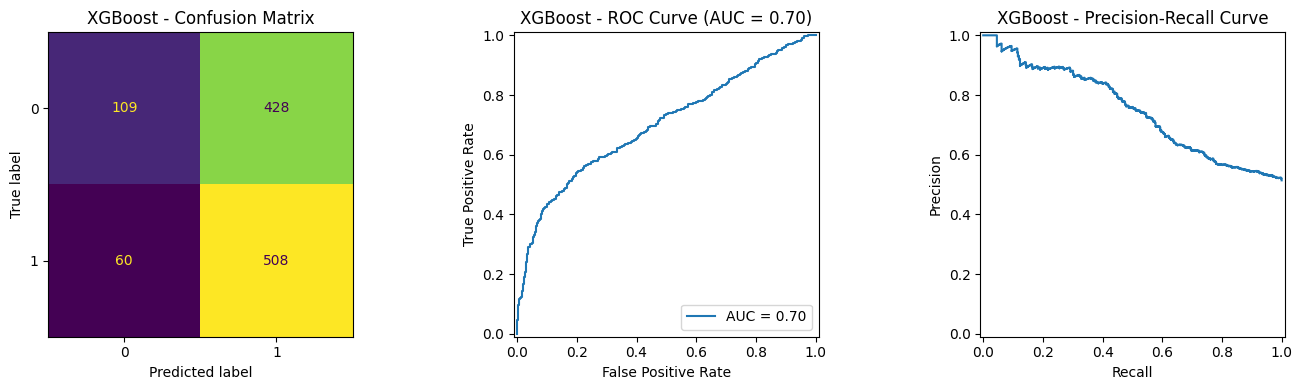

Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       421
           1       0.72      0.79      0.75       684

    accuracy                           0.68      1105
   macro avg       0.66      0.64      0.65      1105
weighted avg       0.67      0.68      0.67      1105

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.82      0.53      0.65       739
           1       0.45      0.77      0.57       366

    accuracy                           0.61      1105
   macro avg       0.64      0.65      0.61      1105
weighted avg       0.70      0.61      0.62      1105

Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.74      0.50      0.60       606
           1       0.57      0.79      0.66       499

    accuracy                           0.63      1105
   macro avg       0.66      0.65      0.63      1105
weighted avg       0

In [63]:
# xgb for model 2
xgb_with_metrics(X2, y2)

Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.66      0.45      0.54       533
           1       0.60      0.78      0.68       567

    accuracy                           0.62      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.63      0.62      0.61      1100

Fold 1 visualized below


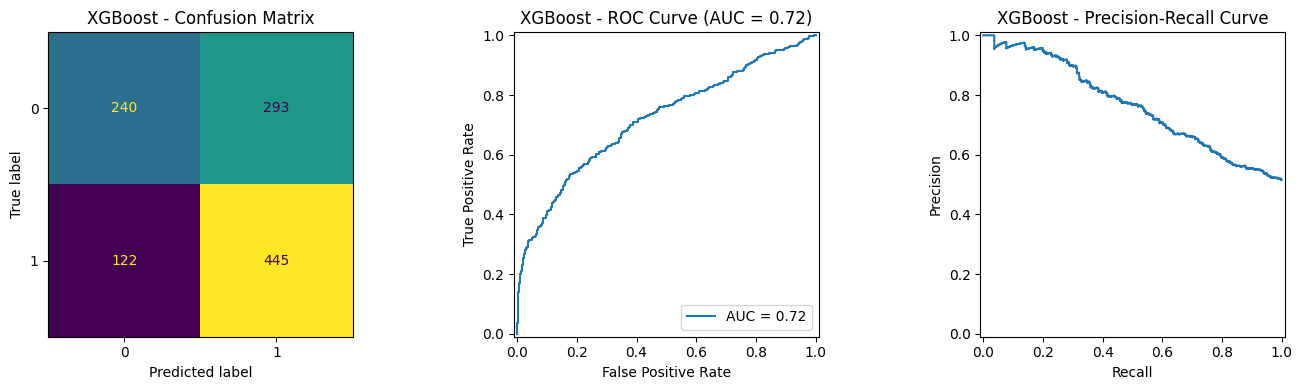

Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.62      0.52      0.56       422
           1       0.73      0.80      0.76       678

    accuracy                           0.69      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.69      0.69      0.69      1100

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       742
           1       0.55      0.69      0.61       358

    accuracy                           0.71      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.74      0.71      0.72      1100

Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       597
           1       0.65      0.70      0.68       503

    accuracy                           0.69      1100
   macro avg       0.69      0.70      0.69      1100
weighted avg       0

In [64]:
# model 3: use advanced features for xgb
nvda_v2 = feature_engineering_2(nvda_v1.copy())
# print(nvda_v2.shape)
# print(nvda_v2.head())

feats3 = [
    'volume',               
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14',
    'prod_bollingerz_rsi',
    'rolling_volatility14',
    'atr',
    'spy_ret5'
]

X3 = nvda_v2[feats3]
y3 = nvda_v2['target_long']

xgb_with_metrics(X3, y3)

Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       533
           1       0.67      0.65      0.66       567

    accuracy                           0.66      1100
   macro avg       0.66      0.66      0.66      1100
weighted avg       0.66      0.66      0.66      1100

Fold 1 visualized below


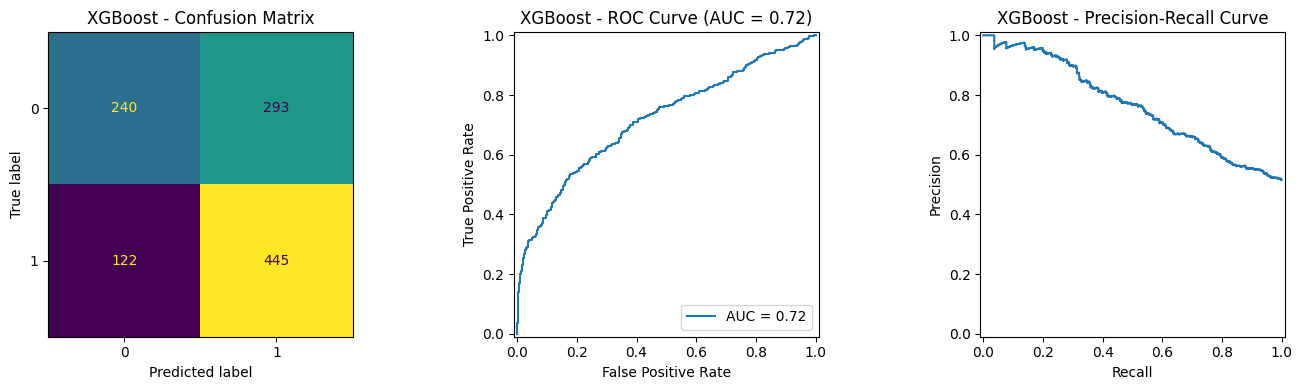

Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       422
           1       0.77      0.71      0.74       678

    accuracy                           0.69      1100
   macro avg       0.68      0.68      0.68      1100
weighted avg       0.70      0.69      0.69      1100

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       742
           1       0.64      0.58      0.60       358

    accuracy                           0.76      1100
   macro avg       0.72      0.71      0.71      1100
weighted avg       0.75      0.76      0.75      1100

Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       597
           1       0.70      0.61      0.65       503

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.70      1100
weighted avg       0

In [66]:
# model 3 with predict proba threshold = 0.7
xgb_with_metrics(X3, y3, predict_proba_threshold=0.7)

In [67]:
# Backtesting